### 6-1. 프로젝트: Mixup 또는 CutMix 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(Mixup 또는 CutMix)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


#### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 Mixup 또는 CutMix augmentation을 적용해 주세요.
```
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')
```

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

tf.config.list_physical_devices('GPU')

=3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     if not is_test and with_aug:
#         ds = ds.map(
#             augment
#         )
#     ds = ds.batch(batch_size)
#     if not is_test and with_cutmix:
#         ds = ds.map(
#             cutmix,
#             num_parallel_calls=2
#         )
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds
# CutMix 관련 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max):
    image_size_x = 224  # 이미지 크기는 224x224로 리사이징했음
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup 관련 함수
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 수정된 데이터셋 적용 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # CutMix와 Mixup은 함께 사용할 수 없으므로 우선순위를 설정
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes#있어야 함

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')
# 추가 데이터셋 생성 - CutMix와 Mixup
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

print('=3')

=3
=3
=3


- Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?  
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
> 코드 구현의 단순화를 위해 하나의 데이터셋 파이프라인에서는 하나의 증강 방식만 선택하도록 설계 (구현 편의상의 선택)
각 augmentation이 어떻게 적용되었는지 시각적으로 확인

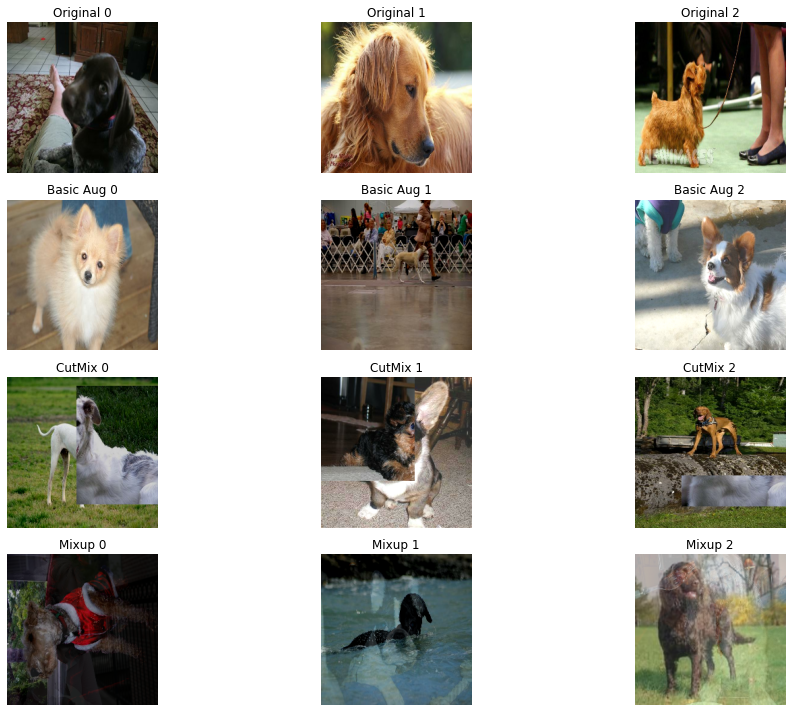

In [4]:
# tfds.show_examples(ds_train, ds_info)
# 증강 결과 시각화하기
def visualize_augmentations():
    plt.figure(figsize=(15, 10))
    
    # 원본 이미지
    for i, (images, labels) in enumerate(ds_train_no_aug.take(1)):
        for j in range(3):
            plt.subplot(4, 3, j+1)
            plt.imshow(images[j])
            plt.title(f'Original {j}')
            plt.axis('off')
    
    # 기본 augmentation 적용 이미지
    for i, (images, labels) in enumerate(ds_train_aug.take(1)):
        for j in range(3):
            plt.subplot(4, 3, j+4)
            plt.imshow(images[j])
            plt.title(f'Basic Aug {j}')
            plt.axis('off')
    
    # CutMix 적용 이미지
    for i, (images, labels) in enumerate(ds_train_cutmix.take(1)):
        for j in range(3):
            plt.subplot(4, 3, j+7)
            plt.imshow(images[j])
            plt.title(f'CutMix {j}')
            plt.axis('off')
    
    # Mixup 적용 이미지
    for i, (images, labels) in enumerate(ds_train_mixup.take(1)):
        for j in range(3):
            plt.subplot(4, 3, j+10)
            plt.imshow(images[j])
            plt.title(f'Mixup {j}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

#### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [5]:
# num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,#include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문
        weights='imagenet',#텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다.
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

# num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')


=3
=3
=3
=3
=3


#### 3. 모델 훈련하기
---
모델을 훈련시켜 주세요.

주의!! 위에서 만든 Mixup 또는 CutMix 을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

- Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?  
우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문
- 아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.

In [6]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

print("\n" + "="*50)
print("TRAINING MIXUP MODEL")
print("="*50 + "\n")

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # Mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

print("\n" + "="*50)
print("TRAINING CUTMIX MODEL")
print("="*50 + "\n")

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # CutMix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

print("\n" + "="*50)
print("TRAINING COMPLETED")
print("="*50 + "\n")

Epoch 1/20


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


750/750 [==============================] - 211s 202ms/step - loss: 2.2099 - accuracy: 0.4423 - val_loss: 3.7841 - val_accuracy: 0.1369
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.6869 - accuracy: 0.8144 - val_loss: 1.1210 - val_accuracy: 0.6704
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2091 - accuracy: 0.9596 - val_loss: 0.9422 - val_accuracy: 0.7211
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0609 - accuracy: 0.9942 - val_loss: 0.9106 - val_accuracy: 0.7350
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0275 - accuracy: 0.9987 - val_loss: 0.8970 - val_accuracy: 0.7421
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0156 - accuracy: 0.9994 - val_loss: 0.9132 - val_accuracy: 0.7431
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0107 - accuracy: 0.9998 - val_loss: 0.9285 - val_accura

750/750 [==============================] - 158s 211ms/step - loss: 1.8535 - accuracy: 0.8334 - val_loss: 1.2002 - val_accuracy: 0.6867
Epoch 17/20
750/750 [==============================] - 158s 211ms/step - loss: 1.8403 - accuracy: 0.8368 - val_loss: 1.3081 - val_accuracy: 0.6677
Epoch 18/20
750/750 [==============================] - 158s 211ms/step - loss: 1.8293 - accuracy: 0.8399 - val_loss: 1.2872 - val_accuracy: 0.6705
Epoch 19/20
750/750 [==============================] - 158s 211ms/step - loss: 1.8126 - accuracy: 0.8428 - val_loss: 1.2983 - val_accuracy: 0.6733
Epoch 20/20
750/750 [==============================] - 158s 211ms/step - loss: 1.8007 - accuracy: 0.8485 - val_loss: 1.2143 - val_accuracy: 0.6896

TRAINING CUTMIX MODEL

Epoch 1/20
750/750 [==============================] - 166s 212ms/step - loss: 3.8942 - accuracy: 0.1969 - val_loss: 3.8927 - val_accuracy: 0.1636
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 3.0204 - accuracy: 0.4103 - v

#### 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

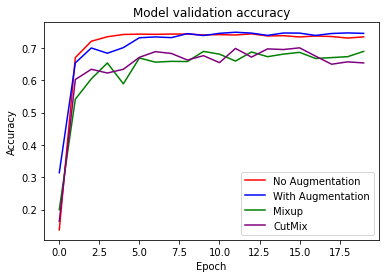

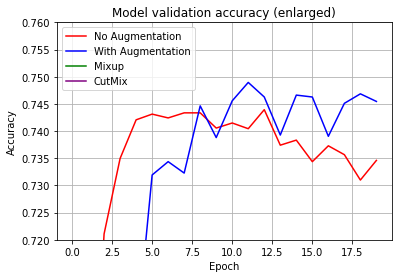

In [7]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# 추가 플롯 생성 - CutMix와 Mixup
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'purple')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.legend(['No Augmentation', 'With Augmentation', 'Mixup', 'CutMix'], loc='lower right')
plt.show()

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# 추가 플롯 생성 - CutMix와 Mixup
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'purple')
# plt.title('Model validation accuracy')
plt.title('Model validation accuracy (enlarged)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.legend(['No Augmentation', 'With Augmentation', 'Mixup', 'CutMix'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

#### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + Mixup 적용, 기본 + CutMix 적용 위 4가지 경우의 데이터 증강 조합에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

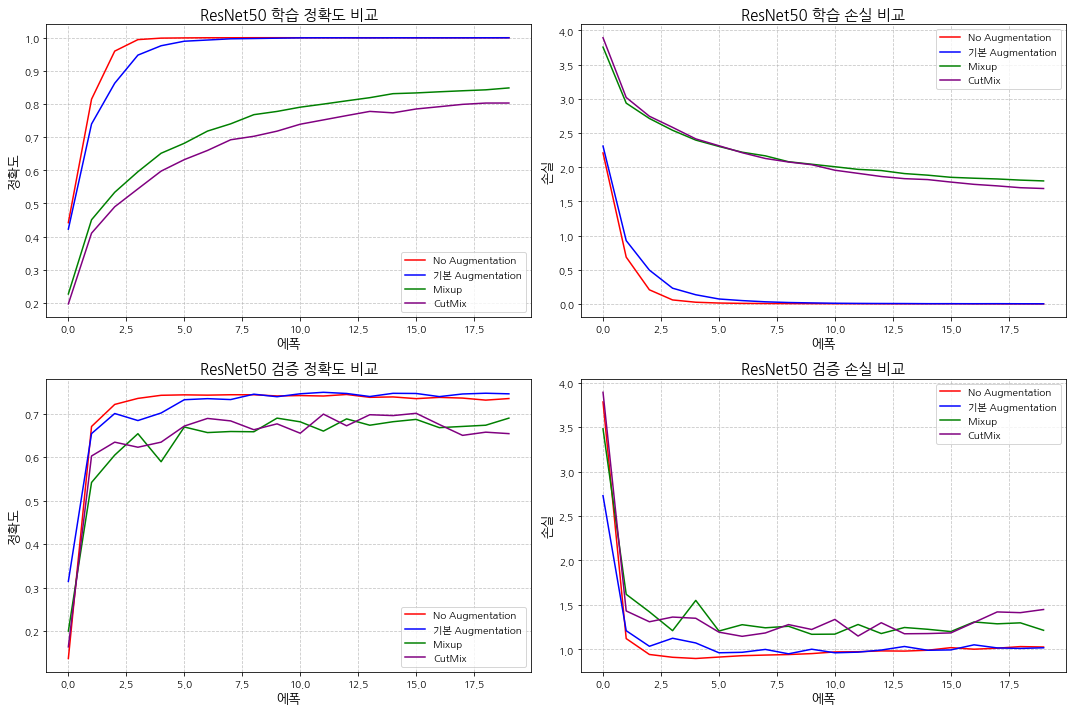

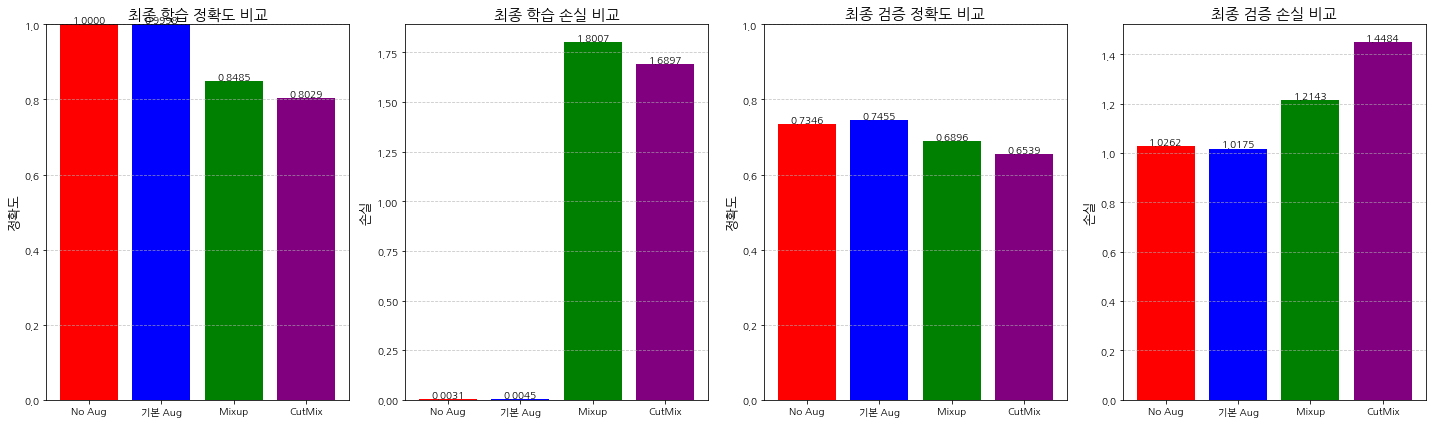

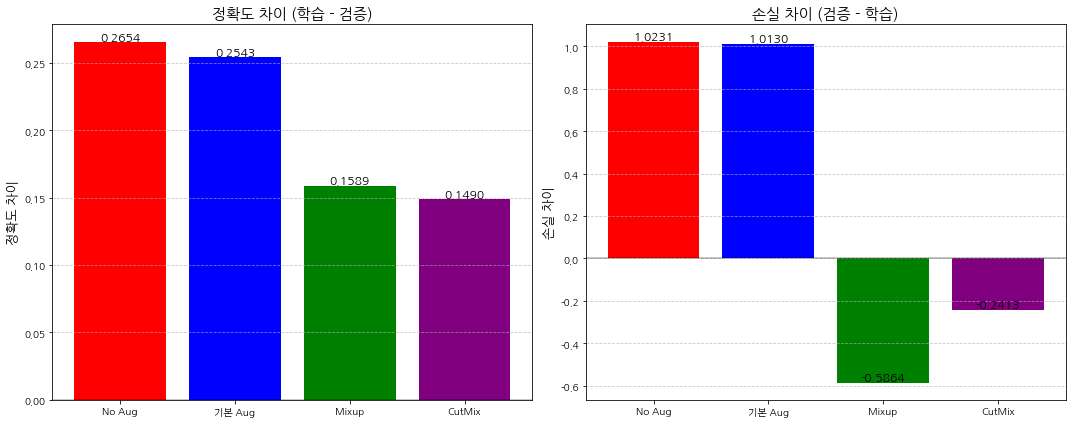

In [9]:
import matplotlib as mpl
# 유니코드 마이너스 기호 대신 ASCII 하이픈 사용
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'

# 1. 학습 정확도와 손실 그래프
plt.figure(figsize=(15, 10))

# 학습 정확도
plt.subplot(2, 2, 1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'purple')
plt.title('ResNet50 학습 정확도 비교', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['No Augmentation', '기본 Augmentation', 'Mixup', 'CutMix'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# 학습 손실
plt.subplot(2, 2, 2)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_cutmix.history['loss'], 'purple')
plt.title('ResNet50 학습 손실 비교', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['No Augmentation', '기본 Augmentation', 'Mixup', 'CutMix'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# 검증 정확도
plt.subplot(2, 2, 3)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'purple')
plt.title('ResNet50 검증 정확도 비교', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['No Augmentation', '기본 Augmentation', 'Mixup', 'CutMix'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# 검증 손실
plt.subplot(2, 2, 4)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'purple')
plt.title('ResNet50 검증 손실 비교', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['No Augmentation', '기본 Augmentation', 'Mixup', 'CutMix'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 2. 최종 에폭 학습 및 검증 지표 바 차트
plt.figure(figsize=(20, 6))

# 최종 학습 정확도
plt.subplot(1, 4, 1)
final_train_accuracies = [
    history_resnet50_no_aug.history['accuracy'][-1],
    history_resnet50_aug.history['accuracy'][-1],
    history_resnet50_mixup.history['accuracy'][-1],
    history_resnet50_cutmix.history['accuracy'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], final_train_accuracies, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)
plt.title('최종 학습 정확도 비교', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 최종 학습 손실
plt.subplot(1, 4, 2)
final_train_losses = [
    history_resnet50_no_aug.history['loss'][-1],
    history_resnet50_aug.history['loss'][-1],
    history_resnet50_mixup.history['loss'][-1],
    history_resnet50_cutmix.history['loss'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], final_train_losses, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)
plt.title('최종 학습 손실 비교', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 최종 검증 정확도
plt.subplot(1, 4, 3)
final_val_accuracies = [
    history_resnet50_no_aug.history['val_accuracy'][-1],
    history_resnet50_aug.history['val_accuracy'][-1],
    history_resnet50_mixup.history['val_accuracy'][-1],
    history_resnet50_cutmix.history['val_accuracy'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], final_val_accuracies, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)
plt.title('최종 검증 정확도 비교', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 최종 검증 손실
plt.subplot(1, 4, 4)
final_val_losses = [
    history_resnet50_no_aug.history['val_loss'][-1],
    history_resnet50_aug.history['val_loss'][-1],
    history_resnet50_mixup.history['val_loss'][-1],
    history_resnet50_cutmix.history['val_loss'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], final_val_losses, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)
plt.title('최종 검증 손실 비교', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3. 학습-검증 차이 비교 (과적합 분석)
plt.figure(figsize=(15, 6))

# 정확도 차이 (학습 - 검증)
plt.subplot(1, 2, 1)
acc_gaps = [
    history_resnet50_no_aug.history['accuracy'][-1] - history_resnet50_no_aug.history['val_accuracy'][-1],
    history_resnet50_aug.history['accuracy'][-1] - history_resnet50_aug.history['val_accuracy'][-1],
    history_resnet50_mixup.history['accuracy'][-1] - history_resnet50_mixup.history['val_accuracy'][-1],
    history_resnet50_cutmix.history['accuracy'][-1] - history_resnet50_cutmix.history['val_accuracy'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], acc_gaps, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)
plt.title('정확도 차이 (학습 - 검증)', fontsize=15)
plt.ylabel('정확도 차이', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 손실 차이 (검증 - 학습)
plt.subplot(1, 2, 2)
loss_gaps = [
    history_resnet50_no_aug.history['val_loss'][-1] - history_resnet50_no_aug.history['loss'][-1],
    history_resnet50_aug.history['val_loss'][-1] - history_resnet50_aug.history['loss'][-1],
    history_resnet50_mixup.history['val_loss'][-1] - history_resnet50_mixup.history['loss'][-1],
    history_resnet50_cutmix.history['val_loss'][-1] - history_resnet50_cutmix.history['loss'][-1]
]
bars = plt.bar(['No Aug', '기본 Aug', 'Mixup', 'CutMix'], loss_gaps, color=['red', 'blue', 'green', 'purple'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)
plt.title('손실 차이 (검증 - 학습)', fontsize=15)
plt.ylabel('손실 차이', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

#### 회고
- ~~시간이 부족(?)해서 epoch를 3회 밖에 돌리지 못했지만, 코드 피어 리뷰를 끝내고 나서 20으로 돌려보겠음 (๑•́ㅿ•̀๑) ᔆᵒʳʳᵞ)~~
- ~~확실한 건 ~~No Augmentation, With Augmentation 경우에는 ~~모두 ~~accuracy 값이 val_accuracy 값보다 컸~~는데~~었음 (accuracy > val_accuracy) Mixup, CutMix 경우에는 특이하게 ~~대체로 ~~accuracy 값이 val_accuracy 값보다 작~~음~~았었음 (accuracy < val_accuracy), 결론적으론 __증강이 무의미해짐__
    - *증강 효과가 나타~~남~~났음*
    - 4 가지 경우 모두 overfitting됨
- 모델에 맞는 데이터셋을 구축하던가 데이터셋에 맞는 모델을 개발해야 할 듯

#### 일반화 정도 비교

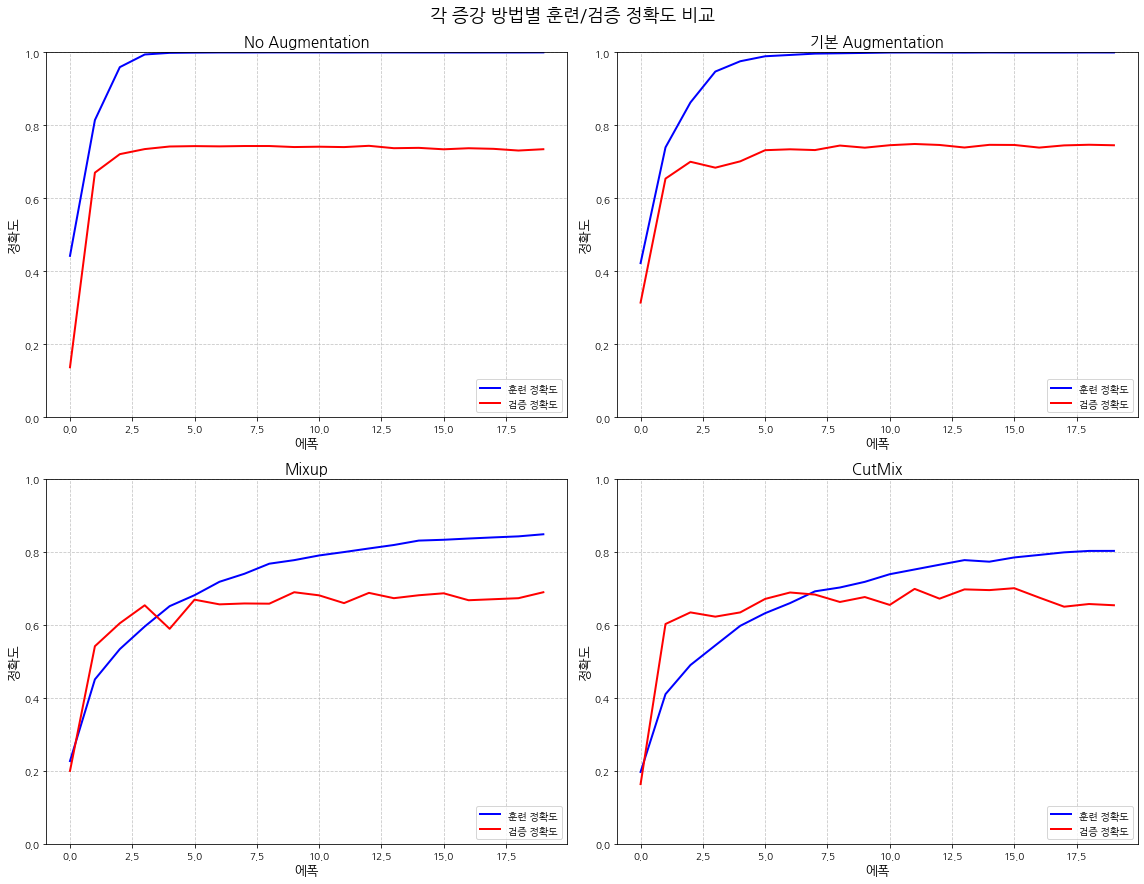

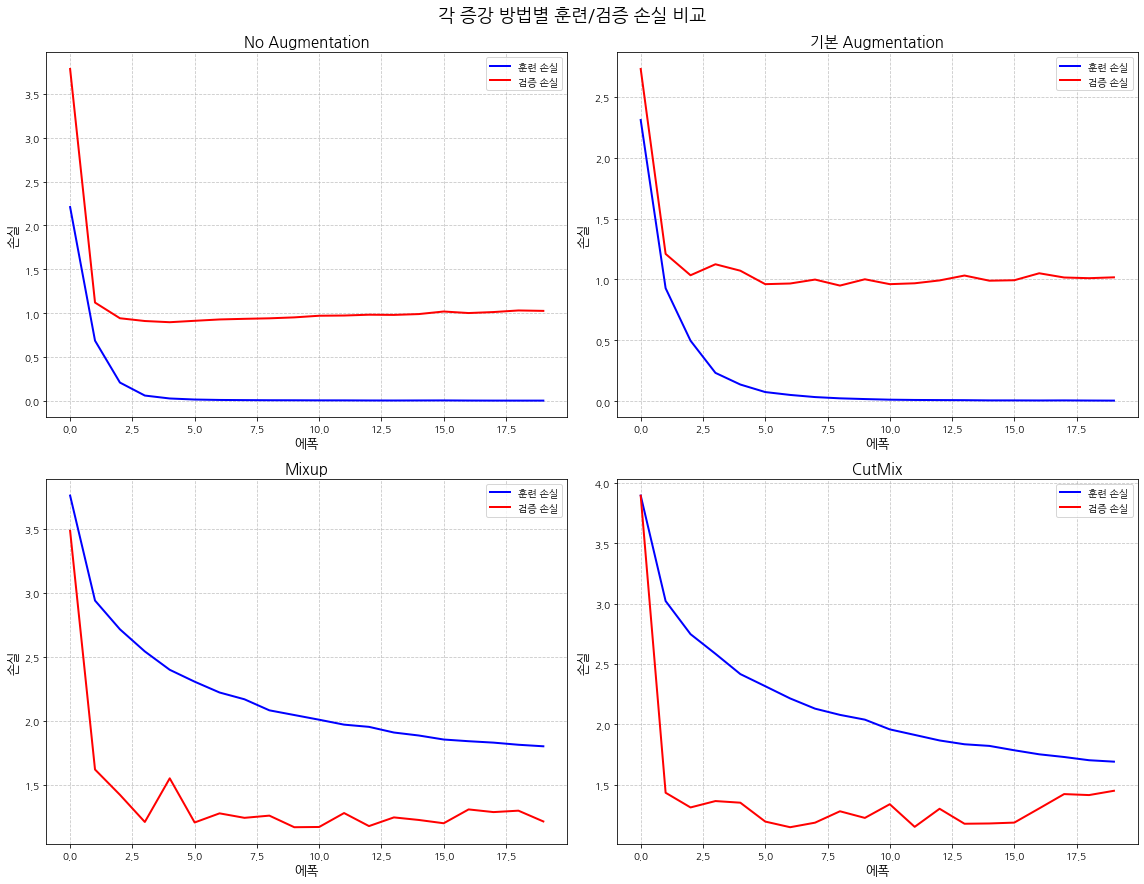

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 마이너스 기호 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'

# 2x2 레이아웃으로 각 증강 방법별 훈련/검증 정확도 비교
plt.figure(figsize=(16, 12))

# 1. No Augmentation
plt.subplot(2, 2, 1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'b-', linewidth=2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r-', linewidth=2)
plt.title('No Augmentation', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 정확도', '검증 정확도'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

# 2. 기본 Augmentation
plt.subplot(2, 2, 2)
plt.plot(history_resnet50_aug.history['accuracy'], 'b-', linewidth=2)
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r-', linewidth=2)
plt.title('기본 Augmentation', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 정확도', '검증 정확도'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

# 3. Mixup
plt.subplot(2, 2, 3)
plt.plot(history_resnet50_mixup.history['accuracy'], 'b-', linewidth=2)
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'r-', linewidth=2)
plt.title('Mixup', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 정확도', '검증 정확도'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

# 4. CutMix
plt.subplot(2, 2, 4)
plt.plot(history_resnet50_cutmix.history['accuracy'], 'b-', linewidth=2)
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r-', linewidth=2)
plt.title('CutMix', fontsize=15)
plt.ylabel('정확도', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 정확도', '검증 정확도'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.suptitle('각 증강 방법별 훈련/검증 정확도 비교', fontsize=18, y=1.02)
plt.show()

# 손실 그래프도 동일한 방식으로 표시
plt.figure(figsize=(16, 12))

# 1. No Augmentation
plt.subplot(2, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'b-', linewidth=2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r-', linewidth=2)
plt.title('No Augmentation', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# 2. 기본 Augmentation
plt.subplot(2, 2, 2)
plt.plot(history_resnet50_aug.history['loss'], 'b-', linewidth=2)
plt.plot(history_resnet50_aug.history['val_loss'], 'r-', linewidth=2)
plt.title('기본 Augmentation', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# 3. Mixup
plt.subplot(2, 2, 3)
plt.plot(history_resnet50_mixup.history['loss'], 'b-', linewidth=2)
plt.plot(history_resnet50_mixup.history['val_loss'], 'r-', linewidth=2)
plt.title('Mixup', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. CutMix
plt.subplot(2, 2, 4)
plt.plot(history_resnet50_cutmix.history['loss'], 'b-', linewidth=2)
plt.plot(history_resnet50_cutmix.history['val_loss'], 'r-', linewidth=2)
plt.title('CutMix', fontsize=15)
plt.ylabel('손실', fontsize=13)
plt.xlabel('에폭', fontsize=13)
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('각 증강 방법별 훈련/검증 손실 비교', fontsize=18, y=1.02)
plt.show()